# A UN TWEET DE CAMBIAR LA ECONOMIA COLOMBIANA
## Proyecto de Inteligencia Artificial
### Alejandro Lobo y Sebastian Arevalo

En este código, utilizando el lenguaje de Python y las herraminetas que encontramos en librerias como numpy, pandas, sklearn y keras, se realizó el analisis de la predicción del precio del dolar, como este afecta a nuestra moneda local y como caracteristicas adicionales como los tweets del precidente podrían afectar esa tendencia o predicción del valor del dolar (para bien o para mal).

### Librerias utilizadas para el correcto funcionamiento del código

En la siguiente celda, se muestran los modulos utilizados para obtener los resultados. Entre estas librerias encontramos operaciones aritmeticas en Python, manejo de estructuras de datos y bibliotecas que encontramos en sklearn para la producción de modelos de aprendizaje supervisado y Machine Learning.

In [8]:
#Librerias para trabajo en Python con operaciones aritmeticas y datos
import pandas as pd
import numpy as np
#Modulos de sklearn, utiles para ML
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score
#Librerias de Keras para series de tiempo con ANN
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
#Para graficar los datos en Python
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Pre-Procesamiento de los datos
Este apartado es importante previo a trabajar con los datos, debido a que los valores atipicos, valores nulos o elementos que no se pueden analizar con Python pueden producir errores a la hora de ejecutar los códigos y afectar los resultados que deberiamos obtener. A continuación, se muestran algunos de los procedimientos elaborados para la preparación de los datos.

In [9]:
# series de tiempo 
df = pd.read_csv('COP=X.csv')
# Verificar los nombres de las columnas disponibles
print(df.columns)
# Mostrar las primeras 5 filas del DataFrame
print(df.head())
print(len(df))
# verificar si hay valores nulos en los datos 
print(df.isnull().sum())
# Eliminar filas con valores faltantes (NaN)
df.dropna(inplace=True)
# Eliminar filas duplicadas
df.drop_duplicates(inplace=True)
# Resetear los índices del DataFrame para reorganizar los indices de las filas ya que eliminamos filas en el Dataframe
df.reset_index(drop=True, inplace=True)
# verificar si hay valores nulos en los datos 
print(df.isnull().sum())
# Seleccionar las columnas numéricas que deseas normalizar
columns_to_normalize = [ 'Open','High', 'Close']
# Obtener los valores mínimos y máximos de las columnas seleccionadas
min_values = df[columns_to_normalize].min()
max_values = df[columns_to_normalize].max()
# Mostrar los valores mínimos y máximos
print("Valores mínimos:")
print(min_values)
print("Valores máximos:")
print(max_values)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
         Date         Open         High          Low        Close  \
0  2022-05-04  4023.919922  4046.919922  4021.199951  4023.919922   
1  2022-05-05  4067.419922  4101.740234  4060.290039  4067.419922   
2  2022-05-06  4089.580078  4089.750000  4032.760010  4089.580078   
3  2022-05-09  4056.000000  4088.570068  4014.066895  4056.000000   
4  2022-05-10  4085.580078  4093.719971  4040.085693  4085.580078   

     Adj Close  Volume  
0  4023.919922     0.0  
1  4067.419922     0.0  
2  4089.580078     0.0  
3  4056.000000     0.0  
4  4085.580078     0.0  
261
Date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Valores mínimos:
Open     3777.25000
High     3777.72998
Close    3777.25000
dtype: float64
Valores máximos:

### Graficas de los conjuntos de datos
En esta sección, se tomaron los datos presentes en el csv y previamente procesados en el apartado previo para tener de forma gráfica la visualización de las variaciones del peso colombiano con respecto al dolar a lo largo de un periodo de tiempo, ademas, se produjo la repartición de los datos en conjuntos de entrenamiento y prueba.

In [10]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
ind_df = df.set_index(['Date'], drop=True)
ind_df.head()

,Adj Close
Date,
2022-05-04,4023.919922
2022-05-05,4067.419922
2022-05-06,4089.580078
2022-05-09,4056.000000
2022-05-10,4085.580078


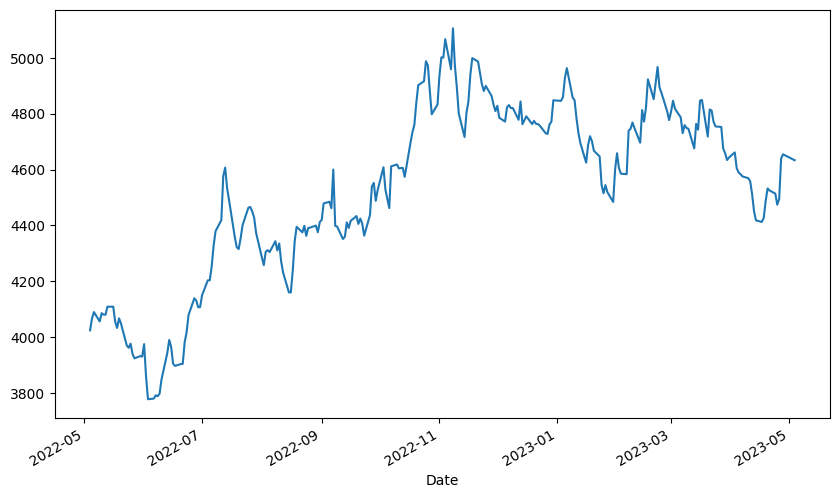

In [13]:
#Grafica con los datos de la variación del dolar en COP
ind_df = ind_df.sort_index()
plt.figure(figsize=(10, 6))
ind_df['Adj Close'].plot();

(259,)
(196,)
(64,)


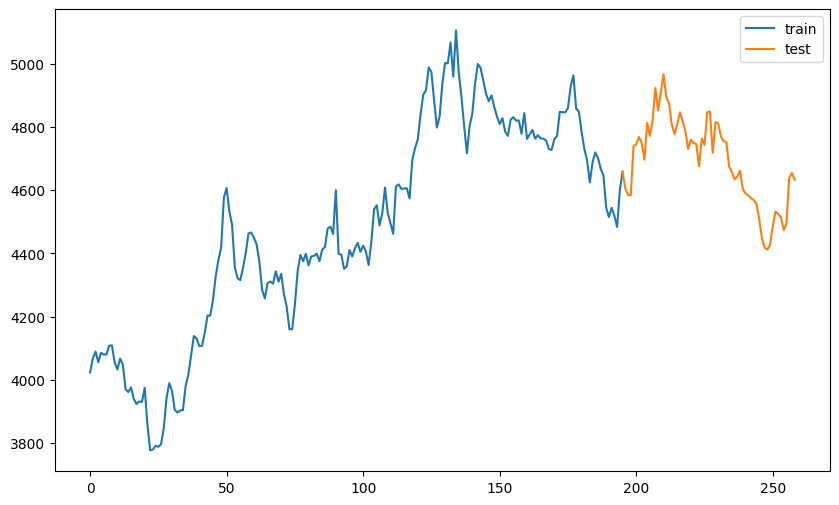

In [14]:
#Grafica con la partición de los datos (Entrenamiento y test)
df2 =  df['Adj Close']
partition=195 
train = df2.loc[:partition]
test = df2.loc[partition:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);
print(df2.shape)
print(train.shape)
print(test.shape)

## Series de tiempo y modelo con ANN
Para obtener las variaciones del precio del dolar y una predicción de su valor, se genero un modelo con redes neuronales, el cual se encarga de analizar los datos de ambos conjuntos por medio de las neuronas especificadas especificadas tanto en la versión de ANN como la versión con la arquitectura LSTM

### Preparación de los datos
Para ambas arquitecturas de las ANN, fue necesario preparar el conjunto de enntrenamiento y el de prueba con el proposito de obtener los mejores resultados, como se muestra en la siguiente celda:

In [15]:
#Preparación de los datos de entrenamiento y testeo
scaler = MinMaxScaler()
scaler.fit(train.values.reshape(-1, 1))
train_sc = scaler.transform(train.values.reshape(-1, 1))
test_sc = scaler.transform(test.values.reshape(-1, 1))

X_train = train_sc[:-1]
y_train = train_sc[1:]
X_test = test_sc[:-1]
y_test = test_sc[1:]

### Modelo de Red Neuronal
En la segunda línea de la celda se pueden identificar las caracteristicas más relevantes del modelo generado, como lo son el número de neuronas, el tamaño y el tipo de activación que esta produce.

In [16]:
#Modelo para la ANN
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
195/195 [==============================] - 1s 1ms/step - loss: 0.0887
Epoch 2/100
195/195 [==============================] - 0s 1ms/step - loss: 0.0223
Epoch 3/100
195/195 [==============================] - 0s 1ms/step - loss: 0.0173
Epoch 4/100
195/195 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 5/100
195/195 [==============================] - 0s 1ms/step - loss: 0.0087
Epoch 6/100
195/195 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 7/100
195/195 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 8/100
195/195 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 9/100
195/195 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 10/100
195/195 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 11/100
195/195 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 12/100
195/195 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 13/100


In [17]:
#Validaciones de la red neuronal con R2 score sobre el conjunto de entrenamiento y prueba
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

7/7 [==============================] - 0s 2ms/step
The R2 score on the Train set is:	0.970
The R2 score on the Test set is:	0.844


In [ ]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)
print(train_sc_df)
X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)
print(X_train)
print(y_train)
X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

X_train_lmse = X_train.reshape(X_train.shape[0],1, X_train.shape[1])
X_test_lmse = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

            Y       X_1
0    0.185641       NaN
1    0.218378  0.185641
2    0.235056  0.218378
3    0.209784  0.235056
4    0.232045  0.209784
..        ...       ...
191  0.577197  0.555319
192  0.558307  0.577197
193  0.531837  0.558307
194  0.619515  0.531837
195  0.663210  0.619515

[196 rows x 2 columns]
          X_1
1    0.185641
2    0.218378
3    0.235056
4    0.209784
5    0.232045
..        ...
191  0.555319
192  0.577197
193  0.558307
194  0.531837
195  0.619515

[195 rows x 1 columns]
            Y
1    0.218378
2    0.235056
3    0.209784
4    0.232045
5    0.228034
..        ...
191  0.577197
192  0.558307
193  0.531837
194  0.619515
195  0.663210

[195 rows x 1 columns]
Train shape:  (195, 1, 1)
Test shape:  (63, 1, 1)


In [ ]:
print(X_train_lmse.shape)
print(X_train.shape)
print(X_train_lmse.shape[1])

(195, 1, 1)
(195, 1)
1


### Modelo Long Short-Term Memory (LSTM)

In [ ]:
lstm_model = Sequential()
#https://keras.io/api/layers/recurrent_layers/lstm/
lstm_model.add(LSTM(20, input_shape=(1, X_train_lmse.shape[2]), activation='tanh', kernel_initializer='lecun_uniform', return_sequences=False,go_backwards=True))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=20, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/20
195/195 [==============================] - 4s 4ms/step - loss: 0.1011
Epoch 2/20
195/195 [==============================] - 1s 4ms/step - loss: 0.0312
Epoch 3/20
195/195 [==============================] - 1s 4ms/step - loss: 0.0204
Epoch 4/20
195/195 [==============================] - 1s 7ms/step - loss: 0.0118
Epoch 5/20
195/195 [==============================] - 1s 5ms/step - loss: 0.0066
Epoch 6/20
195/195 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 7/20
195/195 [==============================] - 1s 6ms/step - loss: 0.0027
Epoch 8/20
195/195 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 9/20
195/195 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 10/20
195/195 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 11/20
195/195 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 12/20
195/195 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 13/20
195/195 [====

In [ ]:
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

2/2 [==============================] - 0s 7ms/step
The R2 score on the Train set is:	0.964
The R2 score on the Test set is:	0.827


2/2 [==============================] - 0s 10ms/step


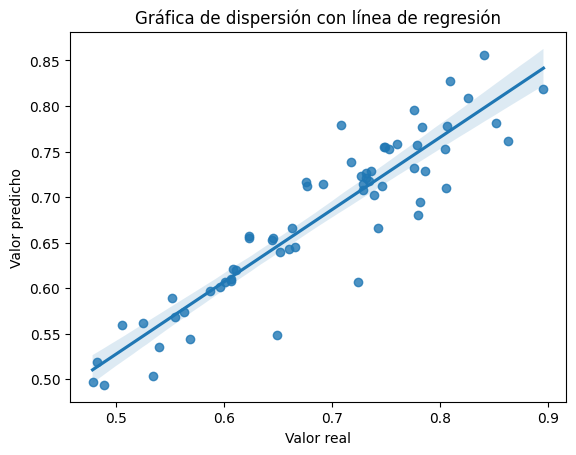

In [ ]:
# Calcular los valores predichos del modelo
y_pred = nn_model.predict(X_test)
#Realizar regresión usando seaborn.regplot
sns.regplot(x=y_test, y=y_pred)
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Gráfica de dispersión con línea de regresión")
plt.show()

In [ ]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

63/63 [==============================] - 1s 2ms/step - loss: 0.0018
NN: 0.001852
LSTM: 0.001827


In [ ]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

2/2 [==============================] - 0s 9ms/step


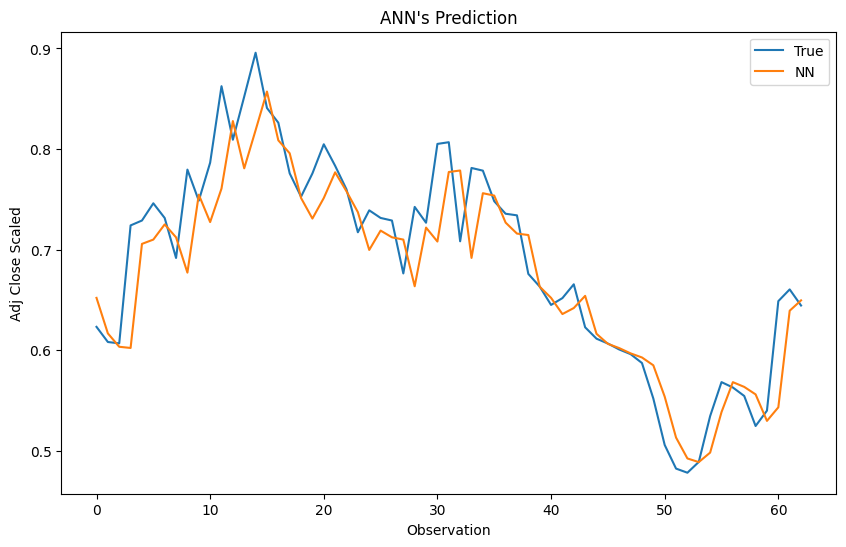

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

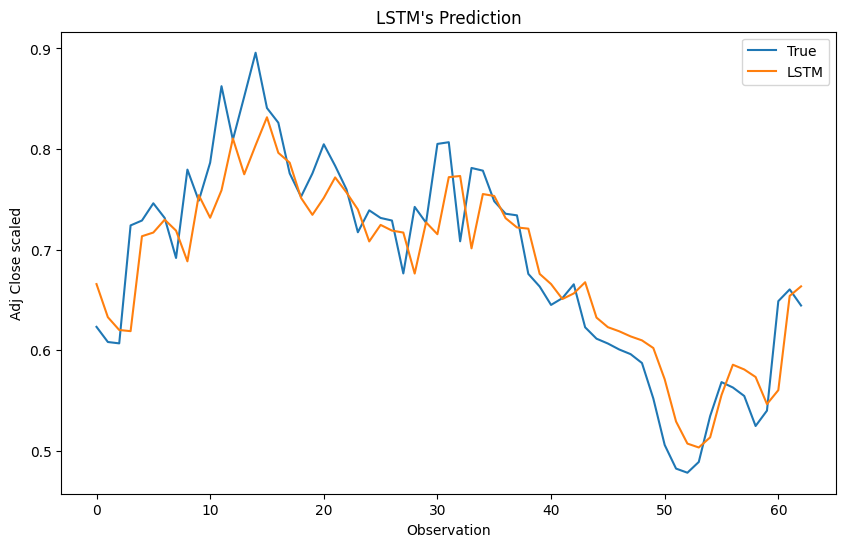

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();

### Cross Validación

In [ ]:
# Definir el número de pliegues para la validación cruzada
num_folds = 5

# Definir una función para crear el modelo Keras Sequential
def create_nn_model():
    nn_model = Sequential()
    nn_model.add(Dense(12, input_dim=1, activation='relu'))
    nn_model.add(Dense(1))
    nn_model.compile(loss='mean_squared_error', optimizer='adam')
    return nn_model

# Crear un estimador envolviendo el modelo Keras Sequential
estimator = KerasRegressor(build_fn=create_nn_model, epochs=100, batch_size=1, verbose=0)

# Aplicar validación cruzada utilizando cross_val_score
nn_scores = cross_val_score(estimator, X_train, y_train, cv=num_folds, scoring='r2')

# Calcular el promedio de las puntuaciones obtenidas en cada pliegue
average_score = np.mean(nn_scores)
print(average_score)
# Imprimir los puntajes individuales de cada pliegue

print("Puntajes individuales:")
for i, score in enumerate(nn_scores):
  print("Pliegue {}: {:.3f}".format(i+1, score))
  

<ipython-input-44-d89916554f67>:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=create_nn_model, epochs=100, batch_size=1, verbose=0)


0.6675244871604689
Puntajes individuales:
Pliegue 1: 0.773
Pliegue 2: 0.777
Pliegue 3: 0.513
Pliegue 4: 0.470
Pliegue 5: 0.805


### PCA

In [ ]:
#PCA
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


# series de tiempo 
df = pd.read_csv('COP=X.csv')

# verificar si hay valores nulos en los datos 

print(df.isnull().sum())
# Eliminar filas con valores faltantes (NaN)
df.dropna(inplace=True)
# Eliminar filas duplicadas
df.drop_duplicates(inplace=True)

# Resetear los índices del DataFrame para reorganizar los indices de las filas ya que eliminamos filas en el Dataframe
df.reset_index(drop=True, inplace=True)
# verificar si hay valores nulos en los datos 
print(df.isnull().sum())

# Seleccionar las columnas numéricas que deseas normalizar
columns_to_normalize = [ 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Crear una instancia de PCA
pca = PCA(n_components=3)  

# Aplicar PCA a los datos normalizados
principal_components = pca.fit_transform(df[columns_to_normalize])

# Obtener los componentes principales

principal_components_df = pd.DataFrame(data=principal_components, columns=['Componente 1', 'Componente 2','Componente 3'])

# Obtener la varianza explicada por cada componente principal

explained_variance = pca.explained_variance_ratio_
print(explained_variance)


Date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
[0.99688171 0.00204073 0.00107756]


In [ ]:
#verificar sí al realizar PCA se beneficia el datraset 
eigenvalues = pca.explained_variance_

variance_ratio_cumulative = np.cumsum(explained_variance) / np.sum(explained_variance)
# Imprimir los eigenvalues

print("Eigenvalues:", eigenvalues)

# Imprimir la proporción de varianza acumulada

print("Variance ratio cumulative:", variance_ratio_cumulative)

Eigenvalues: [0.2828508  0.00057903 0.00030574]
Variance ratio cumulative: [0.99688171 0.99892244 1.        ]
